In [1]:
import re
import time
import pickle
import numpy as np

from edit_distance import SequenceMatcher
import torch
from dataset import SpeechDataset
import matplotlib.pyplot as plt

from neural_decoder.dataset import getDatasetLoaders
import neural_decoder.lm_utils as lmDecoderUtils
from neural_decoder.model import GRUDecoder
import pickle
import argparse
import matplotlib.pyplot as plt
from neural_decoder.dataset import getDatasetLoaders
import neural_decoder.lm_utils as lmDecoderUtils
from neural_decoder.lm_utils import build_llama_1B
from neural_decoder.model import GRUDecoder
from neural_decoder.bit import BiT_Phoneme
import pickle
import argparse
from lm_utils import _cer_and_wer
import json
import os
import copy
from torch.utils.data import Subset

/home3/ebrahim2/miniconda3/envs/speech-bci/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def convert_sentence(s):
    s = s.lower()
    charMarks = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z',
                 "'", ' ']
    ans = []
    for i in s:
        if(i in charMarks):
            ans.append(i)
    
    return ''.join(ans)

In [3]:
base_dir = "/home3/skaasyap/willett"

load_lm = False
# LM decoding hyperparameters
acoustic_scale = 0.8
blank_penalty = np.log(2)

run_for_llm = False

if run_for_llm:
    return_n_best = True
    rescore = False
    nbest = 100
    print("RUNNING IN LLM MODE")
else:
    return_n_best = False
    rescore = False
    nbest = 1
    print("RUNNING IN N-GRAM MODE")

RUNNING IN N-GRAM MODE


In [4]:
if load_lm: 
        
    lmDir = base_dir +'/lm/languageModel'
    ngramDecoder = lmDecoderUtils.build_lm_decoder(
        lmDir,
        acoustic_scale=acoustic_scale, #1.2
        nbest=nbest,
        beam=18
    )
    print("loaded LM")
    
    load_lm = False

### runs MEMO on val days first, then on comp days. 

In [6]:
output_file = 'leia'
    
device = "cuda:2"

if output_file == 'obi':
    model_storage_path = '/data/willett_data/outputs/'
elif output_file == 'leia':
    model_storage_path = '/data/willett_data/leia_outputs/'
    
models_to_run = ['neurips_transformer_time_masked_held_out_days_2', 
                 'neurips_transformer_time_masked_held_out_days_1', 
                 'neurips_transformer_time_masked_held_out_days']

shared_output_file = ''

if len(shared_output_file) > 0:
    print("Writing to shared output file")
    write_mode = "a"
else:
    write_mode = "w"
    
seeds_list = [0,1,2,3]
partition = "competition" # "test"

memo = True
run_lm = False
memo_epochs = 1
memo_augs = 16
nptl_augs = 0
memo_lr = [3e-5, 6e-5, 6e-5]

max_mask_pct = 0.05
num_masks = 20

day_edit_distance = 0
day_seq_length = 0
evaluate_comp = False
val_save_file = 'per_combined'

saveFolder_data = "/data/willett_data/paper_results_obi/"
saveFolder_transcripts = "/data/willett_data/model_transcriptions_comp/"
    
for mn, model_name_str in enumerate(models_to_run):
    
    day_cer_dict = {}
    total_wer_dict = {}
    
    for seed in seeds_list:
    
        day_cer_dict[seed] = []
        total_wer_dict[seed] = []
                

        modelPath = f"{model_storage_path}{model_name_str}_seed_{seed}"
        
        if len(shared_output_file) > 0:
            output_file = f"{shared_output_file}_seed_{seed}"
            print(output_file)
        else:
            output_file = f"{model_name_str}_seed_{seed}"
            
        print(f"Running model: {model_name_str}_seed_{seed}")
            
        with open(modelPath + "/args", "rb") as handle:
            args = pickle.load(handle)
            
        if args['datasetPath'].rsplit('/', 1)[-1] == 'data_log_both':
            data_file = '/data/willett_data/ptDecoder_ctc_both'
            
        elif args['datasetPath'].rsplit('/', 1)[-1] == 'data':
            data_file = '/data/willett_data/ptDecoder_ctc'
            
        elif args['datasetPath'].rsplit('/', 1)[-1] == 'data_log_both_held_out_days':
            data_file = '/data/willett_data/ptDecoder_ctc_both_held_out_days'
            
        elif args['datasetPath'].rsplit('/', 1)[-1] == 'data_log_both_held_out_days_1':
            data_file = '/data/willett_data/ptDecoder_ctc_both_held_out_days_1'
            
        elif args['datasetPath'].rsplit('/', 1)[-1] == 'data_log_both_held_out_days_2':
            data_file = '/data/willett_data/ptDecoder_ctc_both_held_out_days_2'
            
        else:
            data_file = args['datasetPath']
            
        trainLoaders, testLoaders, loadedData = getDatasetLoaders(
            data_file, 8
        )
        
        if 'mask_token_zero' not in args:
            args['mask_token_zero'] = False
                        
        # Instantiate model
        # set training relevant parameters for MEMO, doesn't matter for other runs because they are 
        # only run in eval mode.
        model = BiT_Phoneme(
            patch_size=args['patch_size'],
            dim=args['dim'],
            dim_head=args['dim_head'],
            nClasses=args['nClasses'],
            depth=args['depth'],
            heads=args['heads'],
            mlp_dim_ratio=args['mlp_dim_ratio'],
            dropout=0,
            input_dropout=0,
            look_ahead=args['look_ahead'],
            gaussianSmoothWidth=args['gaussianSmoothWidth'],
            T5_style_pos=args['T5_style_pos'],
            max_mask_pct=max_mask_pct,
            num_masks=num_masks, 
            mask_token_zeros=args['mask_token_zero'], 
            num_masks_channels=0, 
            max_mask_channels=0, 
            dist_dict_path=0, 
        ).to(device)
            
            
        ckpt_path = modelPath + '/modelWeights'
        model.load_state_dict(torch.load(ckpt_path, map_location=device), strict=True)
        model = model.to(device)
        
        optimizer = torch.optim.AdamW(model.parameters(), lr=memo_lr[mn], weight_decay=0, 
                                betas=(args['beta1'], args['beta2']))
        
        for name, p in model.named_parameters():
            
            if name in {
                "to_patch_embedding.1.weight",
                "to_patch_embedding.1.bias",
                "to_patch_embedding.2.weight",
                "to_patch_embedding.2.bias",
                "to_patch_embedding.3.weight",
                "to_patch_embedding.3.bias"
            }:
                p.requires_grad = True
            else:
                p.requires_grad = False
        
        model.eval()

        model_outputs = {
            "logits": [],
            "logitLengths": [],
            "trueSeqs": [],
            "transcriptions": [],
        }
        
        total_edit_distance = 0
        total_seq_length = 0


        testDayIdxs = np.arange(5)
        
        if mn == 2:
            print("MOD VAL")
            # skip day 2, since it's not in the test days
            valDayIdxs = [0,1,3,4,5]
        else:
            valDayIdxs = [0,1,2,3,4]
          
  
        ground_truth_sentences = []
        
        
        for i, testDayIdx in enumerate(testDayIdxs):
            
            day_values = {
                "logits": [],
                "logitLengths": [],
                "trueSeqs": [],
                "transcriptions": [],
            }
        
            ve = valDayIdxs[i]
            
            print("VAL DAY",  ve)
            
            # load val data 
            val_ds = SpeechDataset([loadedData['test'][ve]])
            # reverse, so that TTA updates are done from the last sentence first 
            # doing this because the test sentences are the first 80 sentences in the day
            reversed_val_ds = Subset(val_ds, list(reversed(range(len(val_ds)))))
            
            if evaluate_comp:
                val_loader = torch.utils.data.DataLoader(
                    reversed_val_ds, batch_size=1, shuffle=False, num_workers=0
                )
            else:
                val_loader = torch.utils.data.DataLoader(
                    val_ds, batch_size=1, shuffle=False, num_workers=0
                )
                
            # perform val updates
            for _, (X, y, X_len, y_len, _) in enumerate(val_loader):
                        
                X, y, X_len, y_len, dayIdx = (
                    X.to(device),
                    y.to(device),
                    X_len.to(device),
                    y_len.to(device),
                    torch.tensor([ve], dtype=torch.int64).to(device),
                )
 
                if memo: 
                    
                    model.train()       
                    
                    for _ in range(memo_epochs):
                        
                        logits_aug = model.forward(X, X_len, ve, memo_augs, nptl_augs)  # [memo_augs, T, D]
                        probs_aug = torch.nn.functional.softmax(logits_aug, dim=-1)          # [memo_augs, T, D]
                        marginal_probs = probs_aug.mean(dim=0)                               # [T, D]
                        
                        adjustedLens = model.compute_length(X_len)
                        marginal_probs = marginal_probs[:adjustedLens]
                        
                        # filter out blank tokens
                        max_indices = marginal_probs.argmax(dim=1)
                        marginal_probs = marginal_probs[max_indices != 0]
                        
                        # remove all rows where the max probability is column 0 

                        loss = - (marginal_probs * marginal_probs.log()).sum(dim=-1).mean()

                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()
                        
                model.eval()
                
                with torch.no_grad():
                
                    pred = model.forward(X, X_len, dayIdx)
                    
                if hasattr(model, 'compute_length'):
                    adjustedLens = model.compute_length(X_len)
                else:
                    adjustedLens = ((X_len - model.kernelLen) / model.strideLen).to(torch.int32)
                    
                for iterIdx in range(pred.shape[0]):
                    
                    trueSeq = np.array(y[iterIdx][0 : y_len[iterIdx]].cpu().detach())
            
                    decodedSeq = torch.argmax(
                        torch.tensor(pred[iterIdx, 0 : adjustedLens[iterIdx], :]),
                        dim=-1,
                    ) 
                    
                    decodedSeq = torch.unique_consecutive(decodedSeq, dim=-1)
                    decodedSeq = decodedSeq.cpu().detach().numpy()
                    decodedSeq = np.array([i for i in decodedSeq if i != 0])
                    
                    matcher = SequenceMatcher(
                        a=trueSeq.tolist(), b=decodedSeq.tolist()
                    )
                    
                    total_edit_distance += matcher.distance()
                    total_seq_length += len(trueSeq)
                    
                    day_edit_distance += matcher.distance()
                    day_seq_length += len(trueSeq)
            
                            
            cer_day = day_edit_distance / day_seq_length
            day_cer_dict[seed].append(cer_day)
            print("CER DAY: ", cer_day)
            day_edit_distance = 0 
            day_seq_length = 0

            if evaluate_comp: 
                model.eval()
                    
                # load test
                test_ds = SpeechDataset([loadedData[partition][i]])
                
                reversed_test_ds = Subset(test_ds, list(reversed(range(len(test_ds)))))

                test_loader = torch.utils.data.DataLoader(
                    reversed_test_ds, batch_size=1, shuffle=False, num_workers=0
                )
                    
                # perform comp memo updates
                for j, (X, y, X_len, y_len, _) in enumerate(test_loader):
                            
                    X, y, X_len, y_len, dayIdx = (
                        X.to(device),
                        y.to(device),
                        X_len.to(device),
                        y_len.to(device),
                        torch.tensor([testDayIdx], dtype=torch.int64).to(device),
                    )

                    if memo: 
                                            
                        model.train()
                        
                        for _ in range(memo_epochs):
                            
                            logits_aug = model.forward(X, X_len, testDayIdx, memo_augs)  # [memo_augs, T, D]
                            probs_aug = torch.nn.functional.softmax(logits_aug, dim=-1)          # [memo_augs, T, D]
                            marginal_probs = probs_aug.mean(dim=0)                               # [T, D]

                            adjustedLens = model.compute_length(X_len)
                            marginal_probs = marginal_probs[:adjustedLens]
                            
                            loss = - (marginal_probs * marginal_probs.log()).sum(dim=-1).mean()

                            optimizer.zero_grad()
                            loss.backward()
                            optimizer.step()
                            
                        model.eval()
                        
                    with torch.no_grad():
                        pred = model.forward(X, X_len, dayIdx)
                    
                    if hasattr(model, 'compute_length'):
                        adjustedLens = model.compute_length(X_len)
                    else:
                        adjustedLens = ((X_len - model.kernelLen) / model.strideLen).to(torch.int32)
                        
                    for iterIdx in range(pred.shape[0]):
                        
                        day_values["logits"].append(pred[iterIdx].cpu().detach().numpy())
                        
                        day_values["logitLengths"].append(
                            adjustedLens[iterIdx].cpu().detach().item()
                        )
                        
                        day_values["trueSeqs"].append(trueSeq)
                        
                        decodedSeq = torch.argmax(
                            torch.tensor(pred[iterIdx, 0 : adjustedLens[iterIdx], :]),
                            dim=-1,
                        ) 
                        
                        decodedSeq = torch.unique_consecutive(decodedSeq, dim=-1)
                        decodedSeq = decodedSeq.cpu().detach().numpy()
                        decodedSeq = np.array([i for i in decodedSeq if i != 0])
                        
                
                    transcript = loadedData[partition][i]["transcriptions"][j].strip()
                    transcript = re.sub(r"[^a-zA-Z\- \']", "", transcript)
                    transcript = transcript.replace("--", "").lower()
                    day_values["transcriptions"].append(transcript)
                    
                model_outputs['logits'].extend(reversed(day_values['logits']))
                model_outputs["transcriptions"].extend(reversed(day_values["transcriptions"]))
                model_outputs["trueSeqs"].extend(reversed(day_values["trueSeqs"]))
                model_outputs["logitLengths"].extend(reversed(day_values["logitLengths"]))
                
                # reset day values
                day_values = {
                    "logits": [],
                    "logitLengths": [],
                    "trueSeqs": [],
                    "transcriptions": [],
                }
            
            
            cer = total_edit_distance / total_seq_length
         

            if run_lm:
                
                print("Running n-gram LM")
                
                llm_outputs = []
                start_t = time.time()
                nbest_outputs = []
                
                for j in range(len(model_outputs["logits"])):
                    
                    logits = model_outputs["logits"][j]
                    
                    logits = np.concatenate(
                        [logits[:, 1:], logits[:, 0:1]], axis=-1
                    )  # Blank is last token
                    
                    logits = lmDecoderUtils.rearrange_speech_logits(logits[None, :, :], has_sil=True)
                    
                    nbest = lmDecoderUtils.lm_decode(
                        ngramDecoder,
                        logits[0],
                        blankPenalty=blank_penalty,
                        returnNBest=return_n_best,
                        rescore=rescore,
                    )
                    
                    nbest_outputs.append(nbest)
                    
                time_per_sample = (time.time() - start_t) / len(model_outputs["logits"])
                print(f"N-gram decoding took {time_per_sample} seconds per sample")
                
                if run_for_llm:
                    print("SAVING OUTPUTS FOR LLM")
                    with open(f"{saveFolder_transcripts}{model_name_str}_seed_{seed}_model_outputs.pkl", "wb") as f:
                        pickle.dump(model_outputs, f)
                        
                    with open(f"{saveFolder_transcripts}{model_name_str}_seed_{seed}_nbest.pkl", "wb") as f:
                        pickle.dump(nbest_outputs, f)
                    
                else:
                    # just get perf with greedy decoding
                    for i in range(len(model_outputs["transcriptions"])):
                        model_outputs["transcriptions"][i] = model_outputs["transcriptions"][i].strip()
                        nbest_outputs[i] = nbest_outputs[i].strip()
                    
                    # lower case + remove puncs
                    for i in range(len(model_outputs["transcriptions"])):
                        model_outputs["transcriptions"][i] = convert_sentence(model_outputs["transcriptions"][i])

                    cer, wer = _cer_and_wer(nbest_outputs, model_outputs["transcriptions"], 
                                        outputType='speech', returnCI=True)

                    print("CER and WER after 3-gram LM: ", cer, wer)       
                    
                    out_file = os.path.join(saveFolder_transcripts, output_file)   # no extension per your spec
                    
                    with open(out_file + '.txt', write_mode, encoding="utf-8") as f:
                        f.write("\n".join(nbest_outputs)+ "\n")   # one line per LLM output  
                        
                    total_wer_dict[seed] = wer
                    
                    
        
    if len(val_save_file) > 0:
        print(f"SAVING VAL RESULTS FOR {model_name_str}")
        print("Model performance: ", cer)
        with open(f"{saveFolder_data}{model_name_str}_{val_save_file}.pkl", "wb") as f:
            pickle.dump(day_cer_dict, f)
        


Running model: neurips_transformer_time_masked_held_out_days_2_seed_0
VAL DAY 0


/tmp/ipykernel_2031767/805514885.py:244: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(pred[iterIdx, 0 : adjustedLens[iterIdx], :]),


CER DAY:  0.32175255742134723
VAL DAY 1
CER DAY:  0.36519721577726216
VAL DAY 2
CER DAY:  0.48670599298965544
VAL DAY 3
CER DAY:  0.5025441761495051
VAL DAY 4
CER DAY:  0.5369270736685842
Running model: neurips_transformer_time_masked_held_out_days_2_seed_1
VAL DAY 0
CER DAY:  0.3199189345686161
VAL DAY 1
CER DAY:  0.35081206496519723
VAL DAY 2
CER DAY:  0.47755834829443444
VAL DAY 3
CER DAY:  0.49791840133222315
VAL DAY 4
CER DAY:  0.5244943403228799
Running model: neurips_transformer_time_masked_held_out_days_2_seed_2
VAL DAY 0
CER DAY:  0.314997104806022
VAL DAY 1
CER DAY:  0.3465429234338747
VAL DAY 2
CER DAY:  0.4776438403009319
VAL DAY 3
CER DAY:  0.4980109168285688
VAL DAY 4
CER DAY:  0.5324735572462423
Running model: neurips_transformer_time_masked_held_out_days_2_seed_3
VAL DAY 0
CER DAY:  0.3117158849642926
VAL DAY 1
CER DAY:  0.34784222737819026
VAL DAY 2
CER DAY:  0.46652987945627084
VAL DAY 3
CER DAY:  0.49893607179202515
VAL DAY 4
CER DAY:  0.526071627389126
SAVING VAL RE

In [21]:
marginal_probs

torch.Size([51, 41])

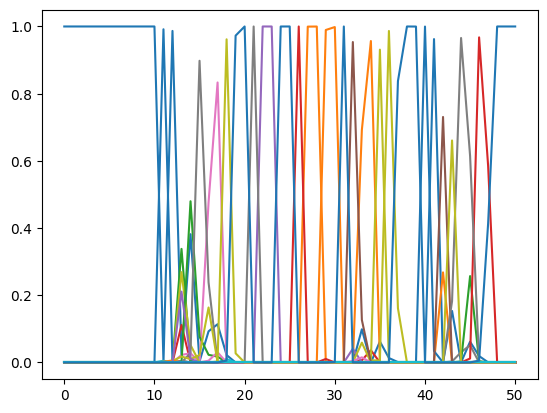

In [31]:
plt.plot(marginal_probs.cpu().detach().numpy())

In [19]:
max_indices = marginal_probs.argmax(dim=1)
filtered_probs = marginal_probs[max_indices != 0]
print(filtered_probs.shape)

torch.Size([50, 41])


In [ ]:
i am a eee